# Python wrapper test

## Weibel simulation


In [13]:
from lib import em2d

# The file has been extensively documented
help( em2d.pySpecies )

# All of the below commands work
laser = em2d.pyPlaneWave( start = 12.8, fwhm = 6.4, a0 = 1, omega0 = 8, sin_pol = 1)

%pdoc laser
laser?
laser??


Help on class pySpecies in module lib.em2d:

class pySpecies(builtins.object)
 |  pySpecies( name, m_q, ppc, udist = None)
 |
 |  Class representing a particle species
 |
 |  Parameters
 |  ----------
 |  name : string
 |      Name of particle species (used for diagnostics)
 |  m_q : float
 |      Mass over charge ratio in simulation units (e.g. for electrons this
 |      should be -1)
 |  ppc : { int, int }
 |      Number of particles per cell. Defaults to None, meaning the object
 |      will be a view of an existing cppSpecies object.
 |  udist : object
 |      Velocity distribution to use, defaults to pyNone (0 velocity)
 |
 |  Methods defined here:
 |
 |  __reduce__ = __reduce_cython__(...)
 |
 |  __setstate__ = __setstate_cython__(...)
 |
 |  gather(self, q)
 |      gather( q )
 |
 |      Gathers specied quantity into a contiguous grid
 |
 |      Parameters
 |      ----------
 |      q : string
 |          Quantity to gather, must be one of 'x', 'y', 'ux', 'uy' or 'uz'
 |
 |     

Type:        pyPlaneWave
String form: <em2d.pyPlaneWave object at 0x1140bf370>
File:        ~/Source/zpic/zpic-parallel/openmp/python/lib/em2d.cpython-313-darwin.so
Docstring:  
pyPlaneWave( start = 0, fwhm = 0, rise = 0, flat = 0, fall = 0,
                a0 = 0, omega0 = 0, polarization = 0,
                cos_pol = 0, sin_pol = 0 )

Class representing plane wave laser pulse

Parameters
----------
start : float
    Start position of laser pulse (front)
fwhm : float
    Laser pulse FWHM, overrides rise / flat / fall parameters
rise : float
    Laser pulse rise time
flat : float
    Laser pulse flat time
fall : float
    Laser pulse fall time
a0 : float
    Normalized peak vector potential of the pulse
omega0 : float 
    Laser frequency normalized to simulation frequency
polarization : float
    Polarization angle in radians. Will be ignored unless cos_pol and
    sin_pol are both 0
cos_pol : float
    Cosine of the polarization angle
sin_pol : float
    Sine of the polarization ang


### Prepare and run simulation

The `dims` variable corresponds to the global grid size. The cell size is set to $0.1^2$

In [2]:
from lib import em2d

# Grid parameters
dims   = [ 128, 128 ]
ntiles = [ 8, 8 ]
box = [ 0.1 * dims[0], 0.1 * dims[1] ]

# Simulation time
tmax   = 35.0

# Particle species
electrons = em2d.pySpecies( "electrons", -1, [4,4], 
                           udist = em2d.pyThermalCorr( [0.1, 0.1, 0.1], [ 0, 0, +0.6 ] ) )

positrons = em2d.pySpecies( "positrons", +1, [4,4], 
                           udist = em2d.pyThermalCorr( [0.1, 0.1, 0.1], [ 0, 0, -0.6 ] ) )


# Create simulation object
nx = [ dims[0]/ntiles[0], dims[1]/ntiles[1] ]
dt = 0.07
sim = em2d.pySimulation( ntiles, nx, box, dt, species = [electrons, positrons] )

# Iterate up to tmax
while sim.t < tmax:
    sim.advance()

print( "Simulation run up to t = {}".format(sim.t))

Simulation run up to t = 35.0


### Plot data directly from memory

Simulation objects have `plot`/`vplot` methods that may be called for generating a plot similar to what you would obtain by saving the file and opening it through `visxd`.

(*info*) Energy at n = 500, t = 35
(*info*) electrons = 14.2937
(*info*) positrons = 14.3859
(*info*) Total particle energy = 28.6796
(*info*) Electric field = 4023.64
(*info*) Magnetic field = 1895.56
(*info*) total = 5947.88


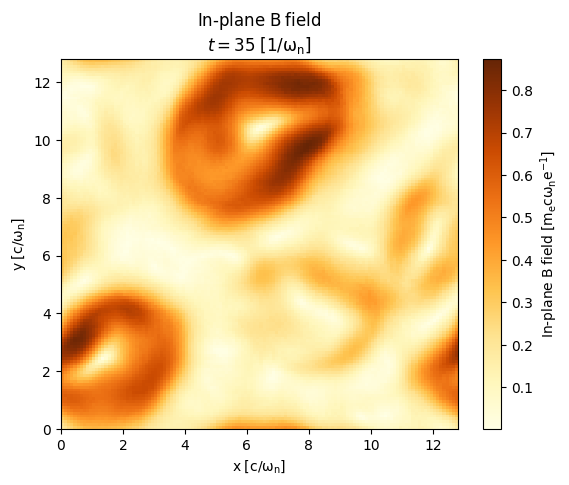

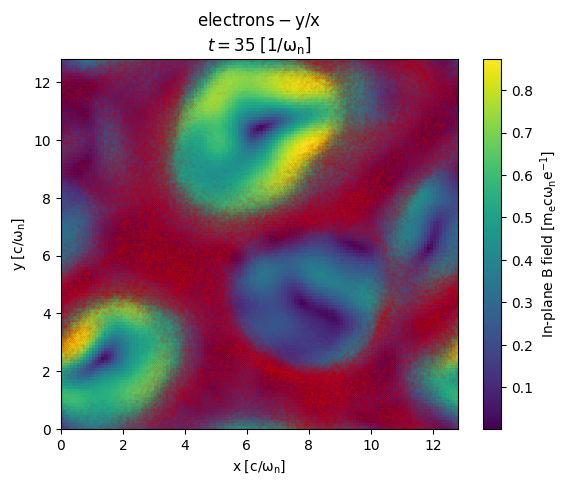

In [2]:
# Print energy information
sim.energy_info()

# sim.emf.plot('E','x', vsim = True, cmap = "RdYlBu")
sim.emf.vplot('B', cmap = "YlOrBr")

# sim.current.vplot()

# Overlap particle data
sim.emf.vplot('B', show = False)
electrons.plot( 'x', 'y', c = 'r', grid = False )

### Access simulation data

Data is returned as NumPy arrays. Note that the data is copied from simulation memory each time the `gather()` functions are called.

In [6]:
Bx = sim.emf.B.gather('x')

Jz = sim.current.J.gather('z')

e_ux = electrons.gather('ux')
e_ux

array([ 0.03148871,  0.00189803,  0.27164602, ...,  0.3635941 ,
        0.09114744, -0.0400355 ], shape=(262144,), dtype=float32)

### Save data to disk

In [ ]:
sim.emf.save('B','x')
sim.emf.save('B','y')
sim.emf.save('B','z')

sim.current.save( 'z' )

# Save particle data
electrons.save()